# 1. Import libraries

In [39]:
# data manipulation
import pandas as pd
from darts import TimeSeries

# models
from darts.models import RegressionEnsembleModel, NaiveDrift, NaiveEnsembleModel

# warnings
import warnings
warnings.filterwarnings('ignore')

# 2. Load data

In [2]:
dataset = pd.read_csv('../results/prepared_data.csv')

# set the column type for column with date
dataset['Data'] = pd.to_datetime(dataset['Data'], format='%Y-%m-%d')

dataset

,Data,BARDO (150160220) Stan wody [cm],BIAŁOBRZEZIE (150160250) Stan wody [cm],BOGDAJ (151170060) Stan wody [cm],BOGDASZOWICE (151160180) Stan wody [cm],BOJANÓW (150180040) Stan wody [cm],BORÓW (150160280) Stan wody [cm],BRANICE (150170170) Stan wody [cm],BRZEG (150170090) Stan wody [cm],BRZEG DOLNY (151160170) Stan wody [cm],...,RUDNA (251160140) Brak pomiaru,STARE OLESNO (250180030) Brak pomiaru,SUKOWICE (250180330) Brak pomiaru,SZALEJÓW GÓRNY (250160840) Brak pomiaru,SZCZAWNO-ZDRÓJ (250160130) Brak pomiaru,TWARDOCICE (251150280) Brak pomiaru,WALIM (250160270) Brak pomiaru,ZIELINA (250170280) Brak pomiaru,ŁABĘDY (250180330) Brak pomiaru,ŁANY (251170420) Brak pomiaru
0,2017-11-01,100.0,57.0,291.0,91.0,64.0,153.0,167.0,251.0,286.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2017-11-02,95.0,55.0,285.0,89.0,64.0,145.0,167.0,239.0,285.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2017-11-03,93.0,54.0,290.0,87.0,65.0,139.0,170.0,224.0,258.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2017-11-04,90.0,55.0,296.0,86.0,63.0,136.0,163.0,226.0,218.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2017-11-05,88.0,53.0,291.0,86.0,62.0,133.0,160.0,215.0,244.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,2021-10-27,67.0,50.0,219.0,71.0,55.0,86.0,161.0,175.0,322.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1457,2021-10-28,67.0,50.0,221.0,71.0,57.0,86.0,161.0,170.0,317.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1458,2021-10-29,67.0,50.0,219.0,71.0,54.0,85.0,161.0,170.0,317.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1459,2021-10-30,66.0,52.0,215.0,70.0,55.0,86.0,161.0,169.0,316.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
hierarchy = pd.read_csv('../results/prepared_hierarchy.csv')

hierarchy

,id_meteo,name_meteo,id_hydro,name_hydro,the_same_location
0,0,GŁOGÓW,151160060,GŁOGÓW,1
1,249180550,CIESZYN,149180060,CIESZYN,1
2,249180550,CIESZYN,149180070,CIESZYN,1
3,249180550,CIESZYN,149180030,ŁAZISKA,0
4,249180550,CIESZYN,149180020,CHAŁUPKI,0
...,...,...,...,...,...
84,250160650,MIĘDZYLESIE,150160190,MIĘDZYLESIE,1
85,250160520,LĄDEK-ZDRÓJ,150160230,LĄDEK-ZDRÓJ,1
86,0,KŁODZKO,150160110,SZALEJÓW DOLNY,0
87,250160840,SZALEJÓW GÓRNY,150160080,TŁUMACZÓW,0


In [4]:
hydro_cols = [f"{stations['name_hydro']} ({stations['id_hydro']}) Stan wody [cm]" for _, stations in hierarchy.loc[
                                            :, ['id_hydro', 'name_hydro']].drop_duplicates().iterrows()]
meteo_cols = [f"{stations['name_meteo']} ({stations['id_meteo']}) Suma opadów [mm]" for _, stations in hierarchy.loc[
                                            hierarchy['id_meteo']!=0, ['id_meteo', 'name_meteo']].drop_duplicates().iterrows()]

In [5]:
# Water level
dataset_grouped_water_level = dataset.loc[:, ['Data']+hydro_cols].copy()
dataset_grouped_water_level = dataset_grouped_water_level.melt(id_vars=['Data'])
dataset_grouped_water_level['id_hydro'] = dataset_grouped_water_level['variable'].str.split('(', 1).str[1].str.split(')',
                                                                                                       1).str[0].astype(int)
dataset_grouped_water_level.rename({'value': 'Stan wody [cm]'}, axis=1, inplace=True)
dataset_grouped_water_level = dataset_grouped_water_level[['Data', 'id_hydro', 'Stan wody [cm]']]
dataset_grouped_water_level

,Data,id_hydro,Stan wody [cm]
0,2017-11-01,151160060,354.0
1,2017-11-02,151160060,358.0
2,2017-11-03,151160060,353.0
3,2017-11-04,151160060,352.0
4,2017-11-05,151160060,326.0
...,...,...,...
130024,2021-10-27,150160200,54.0
130025,2021-10-28,150160200,54.0
130026,2021-10-29,150160200,54.0
130027,2021-10-30,150160200,54.0


In [6]:
# Rain
dataset_grouped_rain = dataset.loc[:, ['Data']+meteo_cols].copy()
dataset_grouped_rain = dataset_grouped_rain.melt(id_vars=['Data'])
dataset_grouped_rain['id_meteo'] = dataset_grouped_rain['variable'].str.split('(', 1).str[1].str.split(')',
                                                                                                       1).str[0].astype(int)
dataset_grouped_rain.rename({'value': 'Suma opadów [mm]'}, axis=1, inplace=True)
dataset_grouped_rain = dataset_grouped_rain[['Data', 'id_meteo', 'Suma opadów [mm]']]
dataset_grouped_rain

,Data,id_meteo,Suma opadów [mm]
0,2017-11-01,249180550,NaN
1,2017-11-02,249180550,NaN
2,2017-11-03,249180550,NaN
3,2017-11-04,249180550,NaN
4,2017-11-05,249180550,NaN
...,...,...,...
61357,2021-10-27,250160510,0.0
61358,2021-10-28,250160510,0.0
61359,2021-10-29,250160510,0.0
61360,2021-10-30,250160510,0.0


In [12]:
dataset_grouped = hierarchy.copy()
dataset_grouped = pd.merge(dataset_grouped, dataset_grouped_water_level, how='inner', on=['id_hydro'])
dataset_grouped = pd.merge(dataset_grouped, dataset_grouped_rain, how='left', on=['Data', 'id_meteo'])

dataset_grouped

,id_meteo,name_meteo,id_hydro,name_hydro,the_same_location,Data,Stan wody [cm],Suma opadów [mm]
0,0,GŁOGÓW,151160060,GŁOGÓW,1,2017-11-01,354.0,NaN
1,0,GŁOGÓW,151160060,GŁOGÓW,1,2017-11-02,358.0,NaN
2,0,GŁOGÓW,151160060,GŁOGÓW,1,2017-11-03,353.0,NaN
3,0,GŁOGÓW,151160060,GŁOGÓW,1,2017-11-04,352.0,NaN
4,0,GŁOGÓW,151160060,GŁOGÓW,1,2017-11-05,326.0,NaN
...,...,...,...,...,...,...,...,...
138790,250160510,OŁDRZYCHOWICE KŁODZKIE,150160200,ŻELAZNO,1,2021-10-27,54.0,0.0
138791,250160510,OŁDRZYCHOWICE KŁODZKIE,150160200,ŻELAZNO,1,2021-10-28,54.0,0.0
138792,250160510,OŁDRZYCHOWICE KŁODZKIE,150160200,ŻELAZNO,1,2021-10-29,54.0,0.0
138793,250160510,OŁDRZYCHOWICE KŁODZKIE,150160200,ŻELAZNO,1,2021-10-30,54.0,0.0


In [13]:
pd.date_range(start=dataset_grouped['Data'].min(),
              end=dataset_grouped['Data'].max()).difference(dataset_grouped['Data'].unique())

DatetimeIndex([], dtype='datetime64[ns]', freq='D')

# 3. Save as TimeSeries Object

In [21]:
dataset.loc[:, ['Data']+hydro_cols]

,Data,GŁOGÓW (151160060) Stan wody [cm],CIESZYN (149180060) Stan wody [cm],CIESZYN (149180070) Stan wody [cm],ŁAZISKA (149180030) Stan wody [cm],CHAŁUPKI (149180020) Stan wody [cm],OLZA (149180300) Stan wody [cm],KRZYŻANOWICE (149180010) Stan wody [cm],BOJANÓW (150180040) Stan wody [cm],RACIBÓRZ-MIEDONIA (150180060) Stan wody [cm],...,GORZUCHÓW (150160100) Stan wody [cm],KŁODZKO (150160180) Stan wody [cm],BYSTRZYCA KŁODZKA (150160150) Stan wody [cm],BYSTRZYCA KŁODZKA (150160170) Stan wody [cm],WILKANÓW (150160210) Stan wody [cm],MIĘDZYLESIE (150160190) Stan wody [cm],LĄDEK-ZDRÓJ (150160230) Stan wody [cm],SZALEJÓW DOLNY (150160110) Stan wody [cm],TŁUMACZÓW (150160080) Stan wody [cm],ŻELAZNO (150160200) Stan wody [cm]
0,2017-11-01,354.0,57.0,123.0,176.0,191.0,212.0,211.0,64.0,262.0,...,73.0,116.0,28.0,41.0,90.0,128.0,58.0,126.0,127.0,60.0
1,2017-11-02,358.0,50.0,135.0,168.0,176.0,196.0,192.0,64.0,240.0,...,69.0,113.0,27.0,38.0,89.0,126.0,57.0,123.0,124.0,61.0
2,2017-11-03,353.0,53.0,142.0,172.0,163.0,186.0,181.0,65.0,225.0,...,66.0,111.0,26.0,35.0,89.0,123.0,56.0,121.0,123.0,60.0
3,2017-11-04,352.0,48.0,142.0,167.0,152.0,177.0,169.0,63.0,212.0,...,63.0,109.0,25.0,32.0,88.0,122.0,56.0,119.0,120.0,59.0
4,2017-11-05,326.0,44.0,141.0,159.0,143.0,170.0,158.0,62.0,200.0,...,60.0,107.0,24.0,30.0,88.0,121.0,55.0,117.0,118.0,59.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,2021-10-27,225.0,8.0,131.0,116.0,82.0,154.0,80.0,55.0,126.0,...,44.0,91.0,22.0,13.0,82.0,113.0,46.0,102.0,108.0,54.0
1457,2021-10-28,224.0,8.0,128.0,117.0,82.0,154.0,79.0,57.0,126.0,...,44.0,91.0,22.0,13.0,83.0,113.0,46.0,102.0,109.0,54.0
1458,2021-10-29,214.0,8.0,126.0,117.0,80.0,153.0,78.0,54.0,124.0,...,45.0,89.0,22.0,12.0,83.0,113.0,46.0,102.0,108.0,54.0
1459,2021-10-30,208.0,7.0,126.0,115.0,79.0,152.0,76.0,55.0,122.0,...,44.0,88.0,22.0,12.0,83.0,114.0,45.0,102.0,107.0,54.0


In [22]:
dataset_ts = TimeSeries.from_dataframe(df=dataset.loc[:, ['Data']+hydro_cols],
                                       time_col='Data', value_cols=hydro_cols)

dataset_ts

<TimeSeries (DataArray) (Data: 1461, component: 89, sample: 1)>
array([[[354.],
        [ 57.],
        [123.],
        ...,
        [126.],
        [127.],
        [ 60.]],

       [[358.],
        [ 50.],
        [135.],
        ...,
        [123.],
        [124.],
        [ 61.]],

       [[353.],
        [ 53.],
        [142.],
        ...,
...
        ...,
        [102.],
        [108.],
        [ 54.]],

       [[208.],
        [  7.],
        [126.],
        ...,
        [102.],
        [107.],
        [ 54.]],

       [[209.],
        [  7.],
        [125.],
        ...,
        [102.],
        [108.],
        [ 53.]]])
Coordinates:
  * Data       (Data) datetime64[ns] 2017-11-01 2017-11-02 ... 2021-10-31
  * component  (component) object 'GŁOGÓW (151160060) Stan wody [cm]' ... 'ŻE...
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

Number of components is larger than 10 (89). Plotting only the first 10 components.


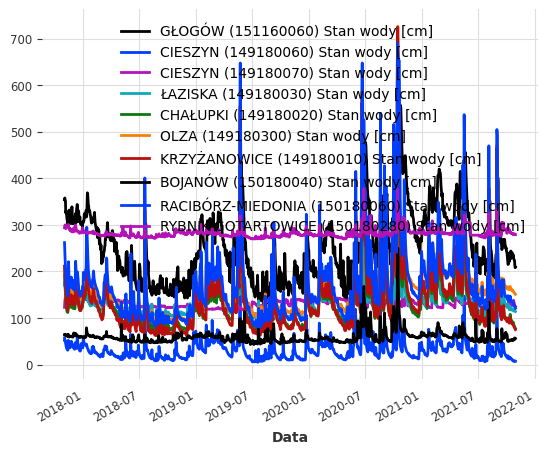

In [23]:
dataset_ts.plot()

# 3. Train Test Split

In [33]:
first_test_date = dataset['Data'].values[-52]
first_test_date = pd.Timestamp(first_test_date)
first_test_date

Timestamp('2021-09-10 00:00:00')

In [36]:
train_dataset, test_dataset = dataset_ts.split_after(first_test_date)

# 4. Modelling & Backtests

In [41]:
# Założenie, że max horyzont to t0+30 days
horizons = 30

## 4.1 Baseline

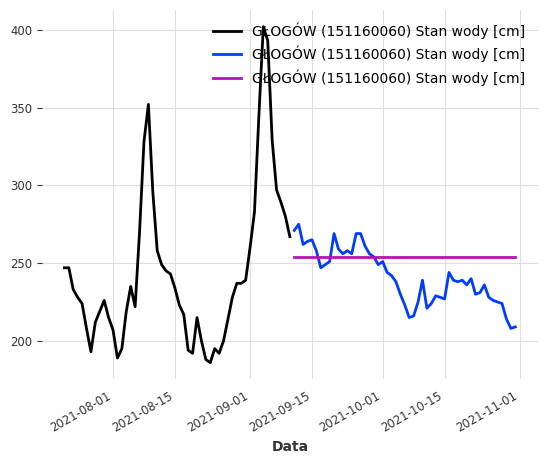

In [59]:
content_baseline_model = [NaiveSeasonal(1)]

baseline_model = RegressionEnsembleModel(forecasting_models=content_baseline_model, regression_train_n_points=horizons)

baseline_model.fit(train_dataset)
train_dataset['GŁOGÓW (151160060) Stan wody [cm]'][-52:].plot()
test_dataset['GŁOGÓW (151160060) Stan wody [cm]'][-52:].plot()
baseline_model.predict(len(test_dataset))['GŁOGÓW (151160060) Stan wody [cm]'].plot()

## 4.2 BayesianRidge

### 4.2.1 Past-observed covariates

### 4.2.2 Past-observed covariates + Future-known covariates

## 4.3 Temporal Fusion Transformer

### 4.3.1 Past-observed covariates

### 4.3.2 Past-observed covariates + Future-known covariates

## 4.4 Linear mixed effects 

### 4.4.1 Past-observed covariates

### 4.4.2 Past-observed covariates + Future-known covariates

# 5. Save Model